In [48]:
import pandas as pd
import numpy as np

df = pd.read_csv("../data/processed/final_absa_results.csv")
df.head()

,Product Name,Brand Name,Price,Rating,clean_review,aspects,aspect_count,sentence,aspect,sentiment
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,it works good but it goes slow sometimes but i...,['performance'],1,it works good but it goes slow sometimes but i...,performance,neutral
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,1,i already had a phone with problems... i know ...,['battery'],1,i already had a phone with problems... i know ...,battery,negative
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,1,i already had a phone with problems... i know ...,['battery'],1,i wish i would have read these comments then i...,battery,negative
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,2,the charging port was loose. i got that solder...,"['battery', 'price']",2,the charging port was loose.,battery,negative
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,2,the charging port was loose. i got that solder...,"['battery', 'price']",2,then needed a new battery as well.,battery,positive


In [49]:
df.columns


Index(['Product Name', 'Brand Name', 'Price', 'Rating', 'clean_review',
       'aspects', 'aspect_count', 'sentence', 'aspect', 'sentiment'],
      dtype='str')

In [50]:
len(df)

346628

In [51]:
df["aspect"].value_counts().head(10)

aspect
battery        83438
display        65209
camera         58457
price          54752
performance    53504
build          31268
Name: count, dtype: int64

In [52]:
aspect_sentiment = (
    df.groupby(["aspect", "sentiment"])
      .size()
      .reset_index(name="count")
)

aspect_sentiment.head(10)

,aspect,sentiment,count
0,battery,negative,29353
1,battery,neutral,22627
2,battery,positive,31458
3,build,negative,5945
4,build,neutral,7721
5,build,positive,17602
6,camera,negative,12645
7,camera,neutral,17250
8,camera,positive,28562
9,display,negative,21037


the sentences are already splitted nice and each have there aspect and there sentiment

In [53]:
aspect_totals = (
    df.groupby("aspect")
      .size()
      .reset_index(name="total_mentions")
)

aspect_totals

,aspect,total_mentions
0,battery,83438
1,build,31268
2,camera,58457
3,display,65209
4,performance,53504
5,price,54752


In [54]:
aspect_dist = aspect_sentiment.merge(
    aspect_totals,
    on="aspect"
)

aspect_dist

,aspect,sentiment,count,total_mentions
0,battery,negative,29353,83438
1,battery,neutral,22627,83438
2,battery,positive,31458,83438
3,build,negative,5945,31268
4,build,neutral,7721,31268
5,build,positive,17602,31268
6,camera,negative,12645,58457
7,camera,neutral,17250,58457
8,camera,positive,28562,58457
9,display,negative,21037,65209


In [55]:
aspect_totals = (
    aspect_sentiment
        .groupby("aspect")["count"]
        .sum()
        .reset_index(name="total")
)

In [56]:
aspect_dist = aspect_sentiment.merge(
    aspect_totals,
    on="aspect"
)

In [57]:
aspect_dist["percentage"] = (
    aspect_dist["count"] / aspect_dist["total"] * 100
).round(2)

aspect_dist.head()

,aspect,sentiment,count,total,percentage
0,battery,negative,29353,83438,35.18
1,battery,neutral,22627,83438,27.12
2,battery,positive,31458,83438,37.70
3,build,negative,5945,31268,19.01
4,build,neutral,7721,31268,24.69


In [58]:
business_view = (
    aspect_dist
        .pivot(
            index="aspect",
            columns="sentiment",
            values="percentage"
        )
        .fillna(0)
        .reset_index()
)

business_view

sentiment,aspect,negative,neutral,positive
0,battery,35.18,27.12,37.70
1,build,19.01,24.69,56.29
2,camera,21.63,29.51,48.86
3,display,32.26,28.32,39.41
4,performance,16.15,21.21,62.64
5,price,13.67,22.86,63.47


## Overall Aspect Sentiment Distribution

This analysis shows how users feel about each product aspect across all reviews.

Key observations:
- Battery and display have the highest negative sentiment counts.
- Price and performance receive the highest positive sentiment.
- Some aspects (e.g., battery) show both high praise and high complaints, indicating inconsistency.

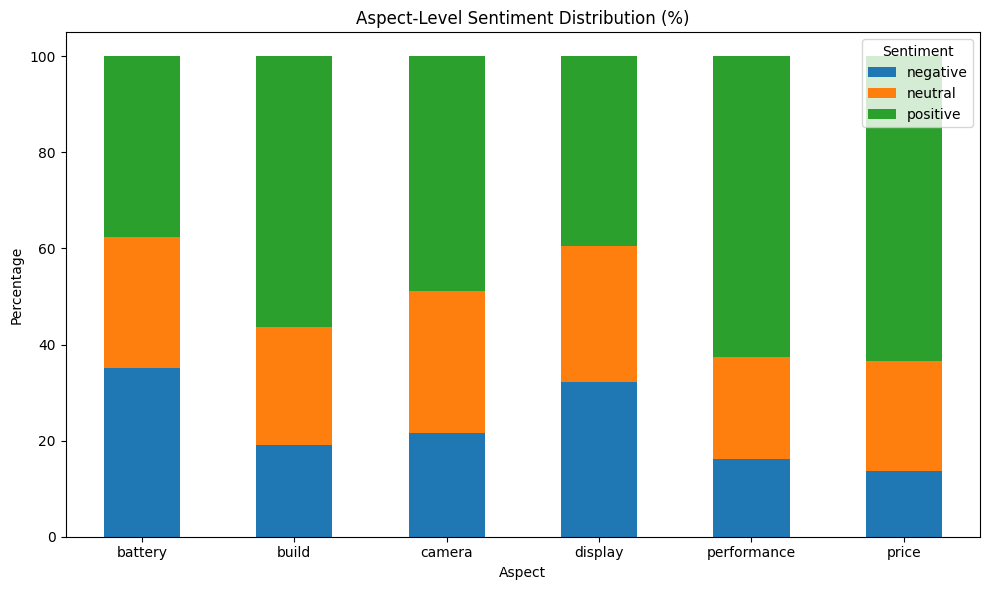

In [59]:
import matplotlib.pyplot as plt

plot_df = business_view.set_index("aspect")

plot_df[["negative", "neutral", "positive"]].plot(
    kind="bar",
    stacked=True,
    figsize=(10,6)
)

plt.title("Aspect-Level Sentiment Distribution (%)")
plt.ylabel("Percentage")
plt.xlabel("Aspect")
plt.legend(title="Sentiment")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Rating vs Aspect Sentiment Mismatch

Users often give 4–5★ ratings but still express negative sentiment about specific aspects.

In [60]:
high_rated = df[df["Rating"] >= 4]
high_rated.shape

(229536, 10)

users say they’re happy in review

In [61]:
high_rated_negative = high_rated[high_rated["sentiment"] == "negative"]
high_rated_negative.shape

(25342, 10)

In [62]:
total_high = high_rated.shape[0]
negative_in_high = high_rated_negative.shape[0]

percentage = (negative_in_high / total_high) * 100
percentage

11.040533946744738

Around 11% of 4–5 star reviews still contain negative aspect-level sentiment

In [63]:
mismatch_aspects = (
    high_rated_negative
    .groupby("aspect")
    .size()
    .reset_index(name="negative_count")
    .sort_values(by="negative_count", ascending=False)
)

mismatch_aspects

,aspect,negative_count
0,battery,7913
3,display,5507
2,camera,4342
5,price,3049
4,performance,2650
1,build,1881


What users complain about even when rating is high?

In [64]:
aspect_totals = (
    high_rated
    .groupby("aspect")
    .size()
    .reset_index(name="total_mentions")
)

mismatch_rate = mismatch_aspects.merge(
    aspect_totals,
    on="aspect"
)

mismatch_rate["mismatch_percentage"] = (
    mismatch_rate["negative_count"] / mismatch_rate["total_mentions"] * 100
).round(2)

mismatch_rate.sort_values("mismatch_percentage", ascending=False)

,aspect,negative_count,total_mentions,mismatch_percentage
0,battery,7913,45819,17.27
1,display,5507,38661,14.24
2,camera,4342,40266,10.78
5,build,1881,22594,8.33
3,price,3049,42740,7.13
4,performance,2650,39456,6.72


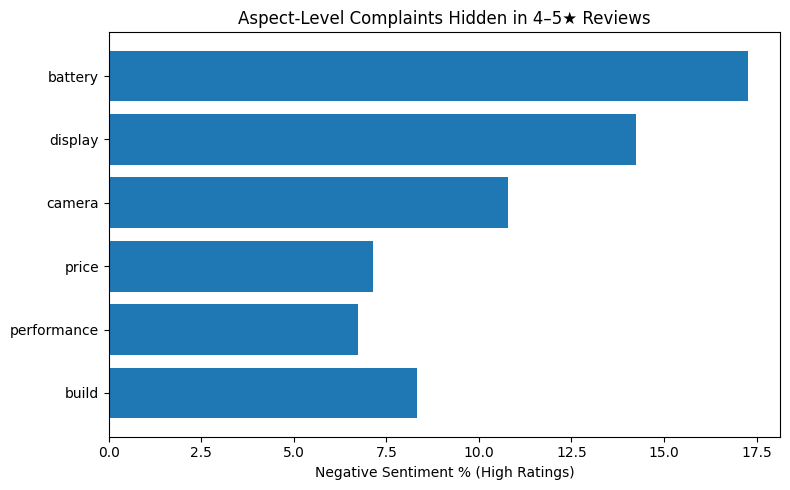

In [65]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.barh(
    mismatch_rate["aspect"],
    mismatch_rate["mismatch_percentage"]
)
plt.xlabel("Negative Sentiment % (High Ratings)")
plt.title("Aspect-Level Complaints Hidden in 4–5★ Reviews")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

I found that many 4–5 star reviews still contain negative aspect-level sentiment.
Battery and display were the most frequent sources of hidden dissatisfaction, proving that star ratings alone are misleading

3. Why users are unhappy — exactly what breaks the product

In [66]:
STOPWORDS = {
    "the","and","is","was","were","with","this","that","for","but",
    "have","has","had","not","you","your","they","them","from",
    "phone","it","its","very","really","just","also","one","would",
    "could","should","there","their","been","after","before"
}

In [68]:
PROBLEM_WORDS = {
    "drain", "dies", "dead", "slow", "issue", "problem", "poor",
    "bad", "fail", "broken", "defective", "short", "fast",
    "overheat", "heat", "waste", "weak", "cheap", "overpriced"
}

In [76]:
import re
def extract_problem_keywords(text, aspect):
    words = re.findall(r"\b[a-z]{3,}\b", text.lower())
    return [
        w for w in words
        if w not in STOPWORDS
        and w != aspect
        and (w in PROBLEM_WORDS)
    ]

In [80]:
negative_df = df[df["sentiment"] == "negative"].copy()


In [81]:
from collections import Counter

aspect_root_causes = {}

for aspect in negative_df["aspect"].unique():
    aspect_sentences = negative_df[
        negative_df["aspect"] == aspect
    ]["sentence"]

    all_words = []
    for s in aspect_sentences:
        all_words.extend(extract_problem_keywords(s, aspect))

    aspect_root_causes[aspect] = Counter(all_words).most_common(10)

In [82]:

for aspect, causes in aspect_root_causes.items():
    print(f"\n🔴 Aspect: {aspect}")
    for word, count in causes:
        print(f"  {word}: {count}")




🔴 Aspect: battery
  bad: 1194
  problem: 991
  dead: 942
  poor: 712
  slow: 564
  dies: 477
  defective: 456
  issue: 421
  broken: 352
  drain: 332

🔴 Aspect: price
  bad: 289
  problem: 193
  cheap: 191
  slow: 162
  poor: 151
  waste: 108
  overpriced: 98
  defective: 97
  broken: 82
  fast: 57

🔴 Aspect: camera
  bad: 777
  poor: 511
  slow: 428
  problem: 347
  issue: 216
  broken: 125
  defective: 101
  cheap: 97
  fast: 88
  waste: 84

🔴 Aspect: build
  poor: 1269
  bad: 508
  cheap: 231
  problem: 145
  slow: 130
  issue: 84
  defective: 52
  short: 48
  waste: 44
  broken: 44

🔴 Aspect: display
  bad: 784
  problem: 653
  broken: 511
  slow: 399
  poor: 293
  issue: 292
  dead: 285
  cheap: 257
  defective: 249
  waste: 141

🔴 Aspect: performance
  slow: 4527
  fast: 882
  bad: 385
  poor: 333
  problem: 191
  cheap: 123
  issue: 113
  dies: 81
  waste: 68
  short: 60


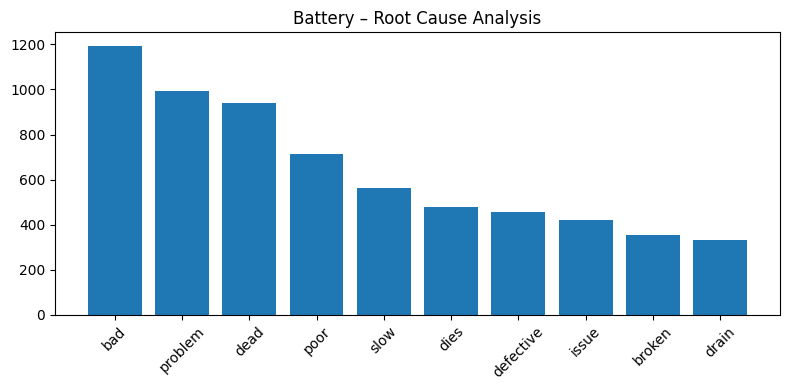

In [73]:
aspect = "battery"
words, counts = zip(*aspect_root_causes[aspect])

plt.figure(figsize=(8,4))
plt.bar(words, counts)
plt.title(f"{aspect.capitalize()} – Root Cause Analysis")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()